<a href="https://colab.research.google.com/github/jaideep11061982/ObjectDetection/blob/master/center_resnet_focal_drop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CenterResnet Starter


In [0]:
 
if install=='Y':

  !pip uninstall -y kaggle
  !pip install --upgrade pip
  !pip install kaggle==1.5.6
  !mkdir -p ~/.kaggle
  !cp kaggle.json ~/.kaggle/
  !chmod 600 /root/.kaggle/kaggle.json
  !kaggle competitions download -c pku-autonomous-driving
  !mkdir data
  !mv *.zip ./data/
  !mv *.csv ./data/
  #!unzip -q ./data/test.zip -d ./data/test/
  !unzip -q ./data/pku-autonomous-driving.zip -d ./data/
  !git clone https://github.com/NVIDIA/apex.git 
  ! pip install -v --no-cache-dir ./apex
 
 
#!pip install efficientnet-pytorch --global-option="--cpp_ext" --global-option="--cuda_ext"
  

In [0]:
#! pip install -v --no-cache-dir  ../input/nvidiaapex/

In [4]:
#!git clone https://github.com/NVIDIA/apex.git 
#! pip install -v --no-cache-dir ./apex
!pip install efficientnet-pytorch

I am very new to these concepts so I am trying out by changing this amazing and probably only 3D model related awesome public kernel by Ruslan
https://www.kaggle.com/hocop1/centernet-baseline

Most of the codes are loaned from there . There are other codes that I took from OFT implementation github . But I dont know what is OFT , so I have not yet implemented it . 

My current score is not from this kernel( as there are some errors in this kernel) , but from some simple architecture modification of the original public kernel. 


In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce
import os
from sklearn.model_selection import train_test_split
from scipy.optimize import minimize
from tqdm.auto import tqdm as tq
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from torchvision import transforms, utils
from apex import amp
PATH = './data/'
#PATH = '../input/pku-autonomous-driving/'
os.listdir(PATH)

['car_models',
 'sample_submission.csv',
 'pku-autonomous-driving.zip',
 'train_images',
 'train_masks',
 'camera',
 'test_images',
 'car_models_json',
 'train.csv',
 'test_masks']

In [0]:
## Constants


SWITCH_LOSS_EPOCH = 5
#import apex


# Load data

In [7]:
train_df = pd.read_csv(PATH + 'train.csv')
test = pd.read_csv(PATH + 'sample_submission.csv')
bad_list = ['ID_1a5a10365',
'ID_1db0533c7',
'ID_53c3fe91a',
'ID_408f58e9f',
'ID_4445ae041',
'ID_bb1d991f6',
'ID_c44983aeb',
'ID_f30ebe4d4']
train_df = train_df.loc[~train_df['ImageId'].isin(bad_list)]

# From camera.zip
camera_matrix = np.array([[2304.5479, 0,        1686.2379],
                          [0,        2305.8757, 1354.9849],
                          [0,         0,          1]], dtype=np.float32)
camera_matrix_inv = np.linalg.inv(camera_matrix)

train_df.head()

,ImageId,PredictionString
0,ID_8a6e65317,16 0.254839 -2.57534 -3.10256 7.96539 3.20066 ...
1,ID_337ddc495,66 0.163988 0.192169 -3.12112 -3.17424 6.55331...
2,ID_a381bf4d0,43 0.162877 0.00519276 -3.02676 2.1876 3.53427...
3,ID_7c4a3e0aa,43 0.126957 -3.04442 -3.10883 -14.738 24.6389 ...
4,ID_8b510fad6,37 0.16017 0.00862796 -3.0887 -3.04548 3.4977 ...


In [0]:
def str2coords(s, names=['id', 'yaw', 'pitch', 'roll', 'x', 'y', 'z']):
    '''
    Input:
        s: PredictionString (e.g. from train dataframe)
        names: array of what to extract from the string
    Output:
        list of dicts with keys from `names`
    '''
    coords = []
    for l in np.array(s.split()).reshape([-1, 7]):
        coords.append(dict(zip(names, l.astype('float'))))
        if 'id' in coords[-1]:
            coords[-1]['id'] = int(coords[-1]['id'])
    return coords

**ImageId** column contains names of images:

In [9]:
def imread(path, fast_mode=False):
    img = cv2.imread(path)
    im = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if not fast_mode and img is not None and len(img.shape) == 3:
        img = np.array(img[:, :, ::-1])
    return img

img = imread(PATH + 'train_images/ID_8a6e65317' + '.jpg')
IMG_SHAPE = img.shape
print(IMG_SHAPE)
#plt.figure(figsize=(15,8))
#plt.imshow(img);

(2710, 3384, 3)


In [10]:
inp = train_df['PredictionString'][0]
print('Example input:\n', inp)
print()
print('Output:\n', str2coords(inp))

Example input:
 16 0.254839 -2.57534 -3.10256 7.96539 3.20066 11.0225 56 0.181647 -1.46947 -3.12159 9.60332 4.66632 19.339 70 0.163072 -1.56865 -3.11754 10.39 11.2219 59.7825 70 0.141942 -3.1395 3.11969 -9.59236 5.13662 24.7337 46 0.163068 -2.08578 -3.11754 9.83335 13.2689 72.9323

Output:
 [{'id': 16, 'yaw': 0.254839, 'pitch': -2.57534, 'roll': -3.10256, 'x': 7.96539, 'y': 3.20066, 'z': 11.0225}, {'id': 56, 'yaw': 0.181647, 'pitch': -1.46947, 'roll': -3.12159, 'x': 9.60332, 'y': 4.66632, 'z': 19.339}, {'id': 70, 'yaw': 0.163072, 'pitch': -1.56865, 'roll': -3.11754, 'x': 10.39, 'y': 11.2219, 'z': 59.7825}, {'id': 70, 'yaw': 0.141942, 'pitch': -3.1395, 'roll': 3.11969, 'x': -9.59236, 'y': 5.13662, 'z': 24.7337}, {'id': 46, 'yaw': 0.163068, 'pitch': -2.08578, 'roll': -3.11754, 'x': 9.83335, 'y': 13.2689, 'z': 72.9323}]


# Data distributions

In [0]:
#lens = [len(str2coords(s)) for s in train['PredictionString']]

#plt.figure(figsize=(15,6))
#sns.countplot(lens);
#plt.xlabel('Number of cars in image');

In [12]:
'''
plt.figure(figsize=(15,6))
sns.distplot(reduce(lambda a, b: a + b, [[c['x'] for c in str2coords(s)] for s in train['PredictionString']]), bins=500);
# sns.distplot([str2coords(s)[0]['x'] for s in train['PredictionString']]);
plt.xlabel('x')
plt.show()
'''

"\nplt.figure(figsize=(15,6))\nsns.distplot(reduce(lambda a, b: a + b, [[c['x'] for c in str2coords(s)] for s in train['PredictionString']]), bins=500);\n# sns.distplot([str2coords(s)[0]['x'] for s in train['PredictionString']]);\nplt.xlabel('x')\nplt.show()\n"

In [13]:
'''
plt.figure(figsize=(15,6))
sns.distplot(reduce(lambda a, b: a + b, [[c['y'] for c in str2coords(s)] for s in train['PredictionString']]), bins=500);
plt.xlabel('y')
plt.show()
'''

"\nplt.figure(figsize=(15,6))\nsns.distplot(reduce(lambda a, b: a + b, [[c['y'] for c in str2coords(s)] for s in train['PredictionString']]), bins=500);\nplt.xlabel('y')\nplt.show()\n"

In [14]:
'''
plt.figure(figsize=(15,6))
sns.distplot(reduce(lambda a, b: a + b, [[c['z'] for c in str2coords(s)] for s in train['PredictionString']]), bins=500);
plt.xlabel('z')
plt.show()
'''

"\nplt.figure(figsize=(15,6))\nsns.distplot(reduce(lambda a, b: a + b, [[c['z'] for c in str2coords(s)] for s in train['PredictionString']]), bins=500);\nplt.xlabel('z')\nplt.show()\n"

In [15]:
'''
plt.figure(figsize=(15,6))
sns.distplot(reduce(lambda a, b: a + b, [[c['yaw'] for c in str2coords(s)] for s in train['PredictionString']]));
plt.xlabel('yaw')
plt.show()
'''

"\nplt.figure(figsize=(15,6))\nsns.distplot(reduce(lambda a, b: a + b, [[c['yaw'] for c in str2coords(s)] for s in train['PredictionString']]));\nplt.xlabel('yaw')\nplt.show()\n"

In [16]:
'''
plt.figure(figsize=(15,6))
sns.distplot(reduce(lambda a, b: a + b, [[c['pitch'] for c in str2coords(s)] for s in train['PredictionString']]));
plt.xlabel('pitch')
plt.show()
'''
#!nvidia-smi

"\nplt.figure(figsize=(15,6))\nsns.distplot(reduce(lambda a, b: a + b, [[c['pitch'] for c in str2coords(s)] for s in train['PredictionString']]));\nplt.xlabel('pitch')\nplt.show()\n"

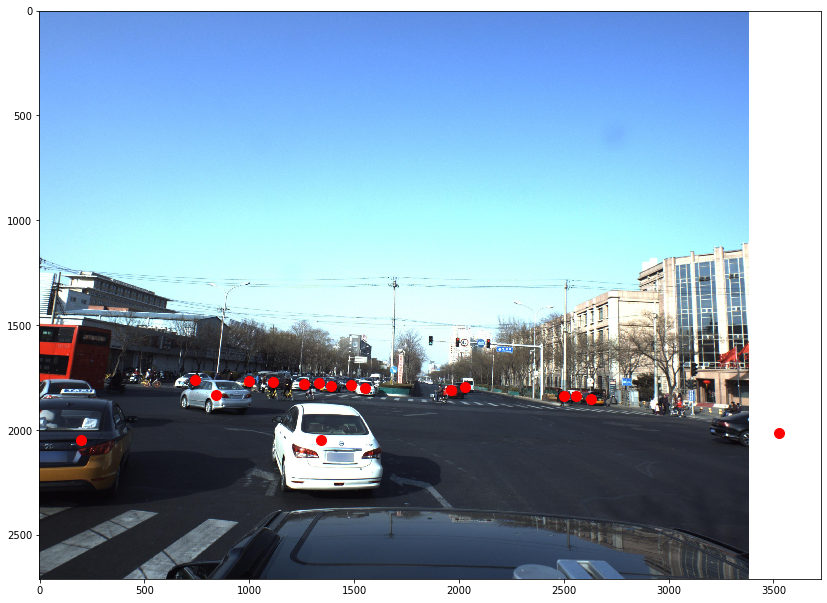

In [17]:

def get_img_coords(s):
    '''
    Input is a PredictionString (e.g. from train dataframe)
    Output is two arrays:
        xs: x coordinates in the image
        ys: y coordinates in the image
    '''
    coords = str2coords(s)
    xs = [c['x'] for c in coords]
    ys = [c['y'] for c in coords]
    zs = [c['z'] for c in coords]
    P = np.array(list(zip(xs, ys, zs))).T
    img_p = np.dot(camera_matrix, P).T
    img_p[:, 0] /= img_p[:, 2]
    img_p[:, 1] /= img_p[:, 2]
    img_xs = img_p[:, 0]
    img_ys = img_p[:, 1]
    img_zs = img_p[:, 2] # z = Distance from the camera
    return img_xs, img_ys

plt.figure(figsize=(14,14))
plt.imshow(imread(PATH + 'train_images/' + train_df['ImageId'][2217] + '.jpg'))
plt.scatter(*get_img_coords(train_df['PredictionString'][2217]), color='red', s=100);

I guess, pitch and yaw are mixed up in this dataset. Pitch cannot be that big. That would mean that cars are upside down.

In [18]:

def rotate(x, angle):
    x = x + angle
    x = x - (x + np.pi) // (2 * np.pi) * 2 * np.pi
    return x
'''
plt.figure(figsize=(15,6))
sns.distplot(reduce(lambda a, b: a + b, [[rotate(c['roll'], np.pi) for c in str2coords(s)] for s in train['PredictionString']]));
plt.xlabel('roll rotated by pi')
plt.show()
'''

"\nplt.figure(figsize=(15,6))\nsns.distplot(reduce(lambda a, b: a + b, [[rotate(c['roll'], np.pi) for c in str2coords(s)] for s in train['PredictionString']]));\nplt.xlabel('roll rotated by pi')\nplt.show()\n"

# 2D Visualization

One point is out of image!

Let's look at the distribution of all points. Image is here just for reference.

In [0]:
xs, ys = [], []

for ps in train_df['PredictionString']:
    x, y = get_img_coords(ps)
    xs += list(x)
    ys += list(y)

#plt.figure(figsize=(18,18))
#plt.imshow(imread(PATH + 'train_images/' + train['ImageId'][2217] + '.jpg'), alpha=0.3)
#plt.scatter(xs, ys, color='red', s=10, alpha=0.2);

Many points are outside!

Let's look at this distribution "from the sky"

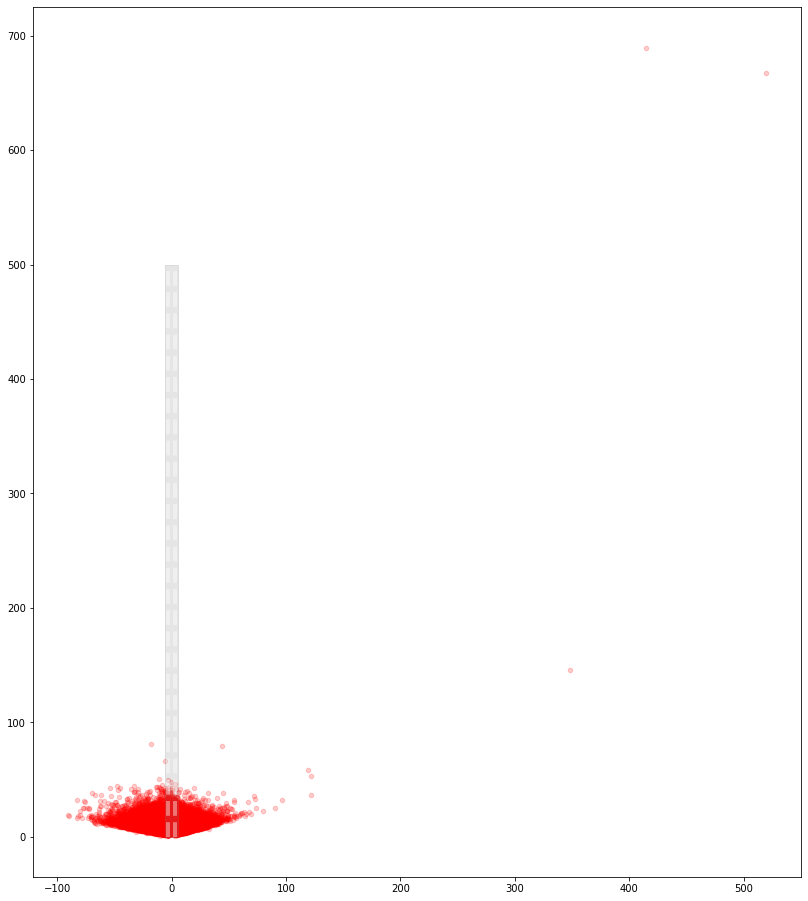

In [20]:
# Cars points
xs, ys = [], []
for ps in train_df['PredictionString']:
    coords = str2coords(ps)
    xs += [c['x'] for c in coords]
    ys += [c['y'] for c in coords]

# Road points
road_width = 6
road_xs = [-road_width, road_width, road_width, -road_width, -road_width]
road_ys = [0, 0, 500, 500, 0]

plt.figure(figsize=(16,16))
plt.axes().set_aspect(1)
# View road
plt.fill(road_xs, road_ys, alpha=0.2, color='gray')
plt.plot([road_width/2,road_width/2], [0,500], alpha=0.4, linewidth=4, color='white', ls='--')
plt.plot([-road_width/2,-road_width/2], [0,500], alpha=0.4, linewidth=4, color='white', ls='--')
# View cars
plt.scatter(xs, ys, color='red', s=20, alpha=0.2);

Some points are very far away

Scale up

In [21]:
'''
plt.figure(figsize=(16,16))
plt.axes().set_aspect(1)
plt.xlim(-50,50)
plt.ylim(0,50)

# View road
plt.fill(road_xs, road_ys, alpha=0.2, color='gray')
plt.plot([road_width/2,road_width/2], [0,100], alpha=0.4, linewidth=4, color='white', ls='--')
plt.plot([-road_width/2,-road_width/2], [0,100], alpha=0.4, linewidth=4, color='white', ls='--')
# View cars
plt.scatter(xs, ys, color='red', s=10, alpha=0.1);
'''

"\nplt.figure(figsize=(16,16))\nplt.axes().set_aspect(1)\nplt.xlim(-50,50)\nplt.ylim(0,50)\n\n# View road\nplt.fill(road_xs, road_ys, alpha=0.2, color='gray')\nplt.plot([road_width/2,road_width/2], [0,100], alpha=0.4, linewidth=4, color='white', ls='--')\nplt.plot([-road_width/2,-road_width/2], [0,100], alpha=0.4, linewidth=4, color='white', ls='--')\n# View cars\nplt.scatter(xs, ys, color='red', s=10, alpha=0.1);\n"

# 3D Visualization
Used code from https://www.kaggle.com/zstusnoopy/visualize-the-location-and-3d-bounding-box-of-car, but made it one function

In [0]:
from math import sin, cos

# convert euler angle to rotation matrix
def euler_to_Rot(yaw, pitch, roll):
    Y = np.array([[cos(yaw), 0, sin(yaw)],
                  [0, 1, 0],
                  [-sin(yaw), 0, cos(yaw)]])
    P = np.array([[1, 0, 0],
                  [0, cos(pitch), -sin(pitch)],
                  [0, sin(pitch), cos(pitch)]])
    R = np.array([[cos(roll), -sin(roll), 0],
                  [sin(roll), cos(roll), 0],
                  [0, 0, 1]])
    return np.dot(Y, np.dot(P, R))

In [0]:
def draw_line(image, points):
    color = (255, 0, 0)
    cv2.line(image, tuple(points[0][:2]), tuple(points[3][:2]), color, 16)
    cv2.line(image, tuple(points[0][:2]), tuple(points[1][:2]), color, 16)
    cv2.line(image, tuple(points[1][:2]), tuple(points[2][:2]), color, 16)
    cv2.line(image, tuple(points[2][:2]), tuple(points[3][:2]), color, 16)
    return image


def draw_points(image, points):
    for (p_x, p_y, p_z) in points:
        cv2.circle(image, (p_x, p_y), int(1000 / p_z), (0, 255, 0), -1)
#         if p_x > image.shape[1] or p_y > image.shape[0]:
#             print('Point', p_x, p_y, 'is out of image with shape', image.shape)
    return image

In [0]:
def visualize(img, coords):
    # You will also need functions from the previous cells
    x_l = 1.02
    y_l = 0.80
    z_l = 2.31
    
    img = img.copy()
    for point in coords:
        # Get values
        x, y, z = point['x'], point['y'], point['z']
        yaw, pitch, roll = -point['pitch'], -point['yaw'], -point['roll']
        # Math
        Rt = np.eye(4)
        t = np.array([x, y, z])
        Rt[:3, 3] = t
        Rt[:3, :3] = euler_to_Rot(yaw, pitch, roll).T
        Rt = Rt[:3, :]
        P = np.array([[x_l, -y_l, -z_l, 1],
                      [x_l, -y_l, z_l, 1],
                      [-x_l, -y_l, z_l, 1],
                      [-x_l, -y_l, -z_l, 1],
                      [0, 0, 0, 1]]).T
        img_cor_points = np.dot(camera_matrix, np.dot(Rt, P))
        img_cor_points = img_cor_points.T
        img_cor_points[:, 0] /= img_cor_points[:, 2]
        img_cor_points[:, 1] /= img_cor_points[:, 2]
        img_cor_points = img_cor_points.astype(int)
        # Drawing
        img = draw_line(img, img_cor_points)
        img = draw_points(img, img_cor_points[-1:])
    
    return img

In [25]:
n_rows = 3
'''
for idx in range(n_rows):
    fig, axes = plt.subplots(1, 2, figsize=(20,20))
    img = imread(PATH + 'train_images/' + train['ImageId'].iloc[idx] + '.jpg')
    axes[0].imshow(img)
    img_vis = visualize(img, str2coords(train['PredictionString'].iloc[idx]))
    axes[1].imshow(img_vis)
    plt.show()
'''

"\nfor idx in range(n_rows):\n    fig, axes = plt.subplots(1, 2, figsize=(20,20))\n    img = imread(PATH + 'train_images/' + train['ImageId'].iloc[idx] + '.jpg')\n    axes[0].imshow(img)\n    img_vis = visualize(img, str2coords(train['PredictionString'].iloc[idx]))\n    axes[1].imshow(img_vis)\n    plt.show()\n"

# Image preprocessing

In [0]:
#!nvidia-smi

In [0]:
'''
IMG_WIDTH = 2048
IMG_HEIGHT = IMG_WIDTH // 4
MODEL_SCALE = 8
'''
''' 
IMG_WIDTH = 1280
IMG_HEIGHT = 512
MODEL_SCALE = 8
''' 
IMG_WIDTH = 1536
#1024
#IMG_HEIGHT = 320
#IMG_WIDTH = 1536
IMG_HEIGHT = 384
#320
img_orig_h, img_orig_w = 2710, 3384
MODEL_SCALE = 8
def _regr_preprocess(regr_dict):
    for name in ['x', 'y', 'z']:
        regr_dict[name] = regr_dict[name] / 100
    regr_dict['roll'] = rotate(regr_dict['roll'], np.pi)
    regr_dict['pitch_sin'] = sin(regr_dict['pitch'])
    regr_dict['pitch_cos'] = cos(regr_dict['pitch'])
    regr_dict.pop('pitch')
    regr_dict.pop('id')
    return regr_dict

def _regr_back(regr_dict):
    for name in ['x', 'y', 'z']:
        regr_dict[name] = regr_dict[name] * 100
    regr_dict['roll'] = rotate(regr_dict['roll'], -np.pi)
    
    pitch_sin = regr_dict['pitch_sin'] / np.sqrt(regr_dict['pitch_sin']**2 + regr_dict['pitch_cos']**2)
    pitch_cos = regr_dict['pitch_cos'] / np.sqrt(regr_dict['pitch_sin']**2 + regr_dict['pitch_cos']**2)
    regr_dict['pitch'] = np.arccos(pitch_cos) * np.sign(pitch_sin)
    return regr_dict

def preprocess_image(img):
    img = img[img.shape[0] // 2:]
    bg = np.ones_like(img) * img.mean(1, keepdims=True).astype(img.dtype)
    bg = bg[:, :img.shape[1] // 4]
    img = np.concatenate([bg, img, bg], 1)
    img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
    return (img / 255).astype('float32')

def get_mask_and_regr(img, labels):
    mask = np.zeros([IMG_HEIGHT // MODEL_SCALE, IMG_WIDTH // MODEL_SCALE], dtype='float32')
    regr_names = ['x', 'y', 'z', 'yaw', 'pitch', 'roll']
    regr = np.zeros([IMG_HEIGHT // MODEL_SCALE, IMG_WIDTH // MODEL_SCALE, 7], dtype='float32')
    coords = str2coords(labels)
    xs, ys = get_img_coords(labels)
    for x, y, regr_dict in zip(xs, ys, coords):
        x, y = y, x
        x = (x - img.shape[0] // 2) * IMG_HEIGHT / (img.shape[0] // 2) / MODEL_SCALE
        x = np.round(x).astype('int')
        y = (y + img.shape[1] // 4) * IMG_WIDTH / (img.shape[1] * 1.5) / MODEL_SCALE
        y = np.round(y).astype('int')
        if x >= 0 and x < IMG_HEIGHT // MODEL_SCALE and y >= 0 and y < IMG_WIDTH // MODEL_SCALE:
            mask[x, y] = 1
            regr_dict = _regr_preprocess(regr_dict)
            regr[x, y] = [regr_dict[n] for n in sorted(regr_dict)]
    return mask, regr

In [0]:
#train_df.columns

In [29]:
def add_number_of_cars(df):
    """df - train or test"""
    df['numcars'] = [int((x.count(' ')+1)/7) for x in df['PredictionString']]
    return df
def coords2str(coords, names=['yaw', 'pitch', 'roll', 'x', 'y', 'z', 'confidence']):
    s = []
    for c in coords:
        for n in names:
            s.append(str(c.get(n, 0)))
    return ' '.join(s)
def remove_out_image_cars(df):

        def isnot_out(x,y):
            # are x,y coordinates within boundaries of the image
            return (x>=0)&(x<=img_orig_w)&(y>=0)&(y<=img_orig_h)

        df = add_number_of_cars(df)

        new_str_coords = []
        counter_all_ls = []
        for idx,str_coords in enumerate(df['PredictionString']):
            coords = str2coords(str_coords, names=['id', 'yaw', 'pitch', 'roll', 'x', 'y', 'z'])
            xs, ys = get_img_coords(str_coords)
            counter = 0
            coords_new = []
            
            for (item,x,y) in zip(coords, xs, ys):
                if isnot_out(x, y):
                    coords_new.append(item)
                    counter += 1
                                
            new_str_coords.append(coords2str(coords_new,  names=['id', 'yaw', 'pitch', 'roll', 'x', 'y', 'z']))
            counter_all_ls.append(counter)
            
        df['new_pred_string']  = new_str_coords 
        df['new_numcars'] = counter_all_ls

        print("num of cars outside image bounds:", df['numcars'].sum()-df['new_numcars'].sum(), 
            "out of all", df['numcars'].sum(), " cars in train")

        del df['PredictionString'], train_df['numcars']
        df.rename(columns={'new_pred_string': 'PredictionString'}, inplace=True)

        return df
    
train_df = remove_out_image_cars(train_df)

num of cars outside image bounds: 997 out of all 49617  cars in train


(2710, 3384, 3)
img.shape (384, 1536, 3) std: 0.28707746
mask.shape (48, 192) std: 0.023286056
regr.shape (48, 192, 7) std: 0.0098476


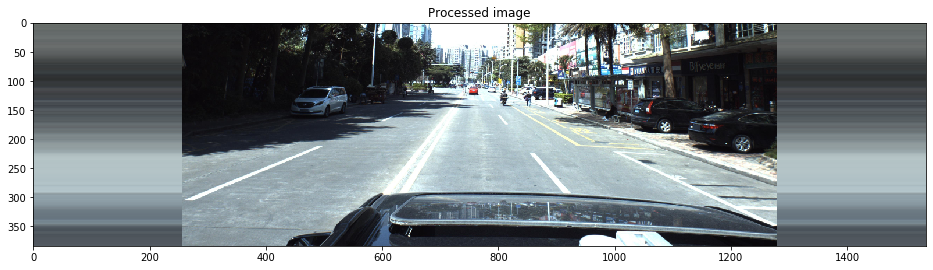

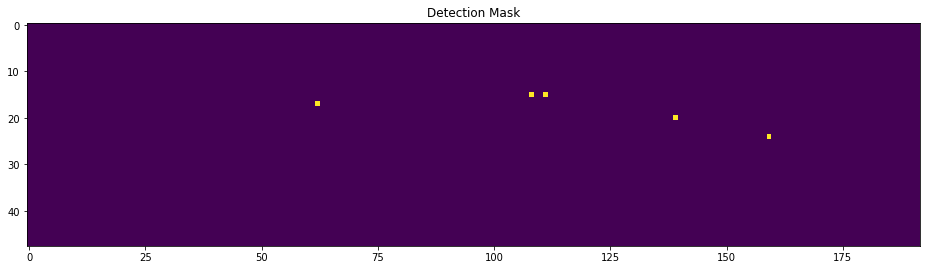

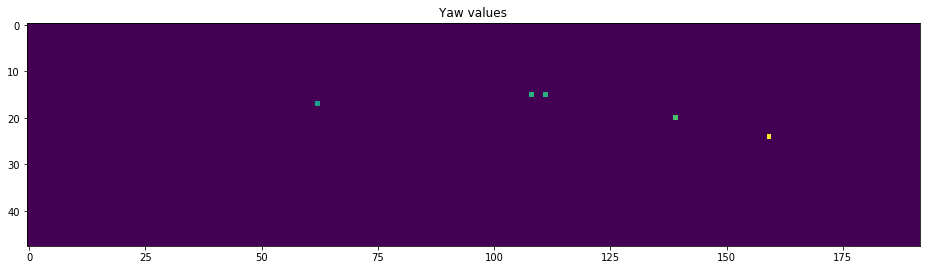

In [30]:
img0 = imread(PATH + 'train_images/' + train_df['ImageId'][0] + '.jpg')
print(img0.shape)
img = preprocess_image(img0)

mask, regr = get_mask_and_regr(img0, train_df['PredictionString'][0])

print('img.shape', img.shape, 'std:', np.std(img))
print('mask.shape', mask.shape, 'std:', np.std(mask))
print('regr.shape', regr.shape, 'std:', np.std(regr))

plt.figure(figsize=(16,16))
plt.title('Processed image')
plt.imshow(img)
plt.show()

plt.figure(figsize=(16,16))
plt.title('Detection Mask')
plt.imshow(mask)
plt.show()

plt.figure(figsize=(16,16))
plt.title('Yaw values')
plt.imshow(regr[:,:,-2])
plt.show()

# PyTorch Dataset

In [0]:
from albumentations import ( Compose, OneOf, RandomBrightnessContrast,
           RandomGamma, HueSaturationValue, RGBShift, MotionBlur, Blur,
           GaussNoise, ChannelShuffle    
                            )
albu_list = [RandomBrightnessContrast(brightness_limit=(-0.3, 0.3), contrast_limit=(-0.3, 0.3), p=0.3),
           RandomGamma(p=0.2), HueSaturationValue(p=0.3), RGBShift(p=0.3), MotionBlur(p=0.1), Blur(p=0.1), 
           GaussNoise(var_limit=(20,100), p=0.2), 
           ChannelShuffle(p=0.2)]

# NOT in colab version: MultiplicativeNoise(multiplier=(0.7, 1.2), p=0.2), ISONoise(p=0.2),               
# GaussNoise(var_limit=(10.0, 50.0), mean=0, always_apply=False, p=0.5)

p_transform_train = 0.1
albu_transform_train = Compose(albu_list, p=p_transform_train)

p_transform_val = 0.05
albu_transform_valid = Compose(albu_list, p=p_transform_val)

In [0]:
def aug_visualize(original_imgs: list, augmented_images: list):
    fig_height = 8*len(original_imgs)
    fig_width = 20
    f, ax = plt.subplots(len(original_imgs), 2, figsize=(fig_width, fig_height))
    
    for i, (img, aug_img) in enumerate(zip(original_imgs, augmented_images)):
        assert len(img.shape)==3 & img.shape[2]==3
        ax[i,0].imshow(img)
        ax[i,0].set_title(f"Original image ", fontsize=12)
        ax[i,1].imshow(aug_img)
        ax[i,1].set_title('Augmented image', fontsize=12)

In [0]:
# [ PATH+'train_images/'+path+'.jpg' for path in paths] 

In [34]:
'''
import random
num_imgs_to_show = 4 
p_transform_demo = 1 
albu_transform_demo = Compose(albu_list, p=p_transform_train)

assert num_imgs_to_show < 10 
paths = random.sample(train_df['ImageId'].tolist(), num_imgs_to_show) 
original_imgs = [cv2.imread(PATH+'train_images/'+path+'.jpg') for path in paths] 
#augmented_imgs = [albu_transform_demo(image=img)['image'] for img in original_imgs] 
#aug_visualize(original_imgs, augmented_imgs)
'''

"\nimport random\nnum_imgs_to_show = 4 \np_transform_demo = 1 \nalbu_transform_demo = Compose(albu_list, p=p_transform_train)\n\nassert num_imgs_to_show < 10 \npaths = random.sample(train_df['ImageId'].tolist(), num_imgs_to_show) \noriginal_imgs = [cv2.imread(PATH+'train_images/'+path+'.jpg') for path in paths] \n#augmented_imgs = [albu_transform_demo(image=img)['image'] for img in original_imgs] \n#aug_visualize(original_imgs, augmented_imgs)\n"

In [0]:
from torchvision import transforms

class CarDataset(Dataset):
    """Car dataset."""

    def __init__(self, dataframe, root_dir, training=True, transform=None):
        self.df = dataframe
        self.root_dir = root_dir
        self.transform = transform
        self.training = training

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        # Get image name
        idx, labels,_ = self.df.values[idx]
        img_name = self.root_dir.format(idx)
        
        # Read image
        img0 = imread(img_name, True)
        image = preprocess_image(img0)
        #image = transforms.ToPILImage(mode='F')(image)
        
        if self.transform:
          None
          image = self.transform(image)
        #image = np.rollaxis(image, 2, 0)
        
        # Get mask and regression maps
        if self.training:
            mask, regr = get_mask_and_regr(img0, labels)
            regr = np.rollaxis(regr, 2, 0)
        else:
            mask, regr = 0, 0
        
        return [image, mask, regr]

In [0]:
train_images_dir = PATH + 'train_images/{}.jpg'
test_images_dir = PATH + 'test_images/{}.jpg'
train_transform = transforms.Compose([
    #transforms.RandomHorizontalFlip(),
    #transforms.RandomRotation((-120, 120)),
    
    transforms.ToTensor()
    #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]
]
    )
df_train, df_dev = train_test_split(train_df, test_size=0.01, random_state=14)
df_test = test

# Create dataset objects
train_dataset = CarDataset(df_train, train_images_dir,transform=train_transform)
dev_dataset = CarDataset(df_dev, train_images_dir,transform=train_transform)
test_dataset = CarDataset(df_test, test_images_dir,transform=train_transform)

Show some generated examples

In [37]:
img, mask, regr = train_dataset[0]
print(img.shape,mask.shape,regr.shape)
'''
plt.figure(figsize=(16,16))
plt.imshow(np.rollaxis(img, 0, 3))
plt.show()

plt.figure(figsize=(16,16))
plt.imshow(mask)
plt.show()

plt.figure(figsize=(16,16))
plt.imshow(regr[-2])
plt.show()
'''
#train_dataset[0]
#train_df.columns

torch.Size([3, 384, 1536]) (48, 192) (7, 48, 192)


'\nplt.figure(figsize=(16,16))\nplt.imshow(np.rollaxis(img, 0, 3))\nplt.show()\n\nplt.figure(figsize=(16,16))\nplt.imshow(mask)\nplt.show()\n\nplt.figure(figsize=(16,16))\nplt.imshow(regr[-2])\nplt.show()\n'

In [0]:
BATCH_SIZE = 8

# Create data generators - they will produce batches
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=6)
dev_loader = DataLoader(dataset=dev_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=6)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=6)

In [0]:
#!nvidia-smi
#batch = next(iter(train_loader))

In [0]:
#torch.tensor(train_dataset[0]).size()
#train_dataset[0].size()

In [41]:
'''
import torchvision
grid = torchvision.utils.make_grid(torch.tensor(train_dataset[0][0]), nrow=3)
print(len(grid))
plt.figure(figsize=(15,15))
plt.imshow(grid.permute(1,2,0) )
'''

'\nimport torchvision\ngrid = torchvision.utils.make_grid(torch.tensor(train_dataset[0][0]), nrow=3)\nprint(len(grid))\nplt.figure(figsize=(15,15))\nplt.imshow(grid.permute(1,2,0) )\n'

# PyTorch Model

In [0]:
class double_conv(nn.Module):
    '''(conv => BN => ReLU) * 2'''
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x

class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(up, self).__init__()

        #  would be a nice idea if the upsampling could be learned too,
        #  but my machine do not have enough memory to handle all those weights
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch//2, in_ch//2, 2, stride=2)

        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2=None):
        x1 = self.up(x1)
        
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, (diffX // 2, diffX - diffX//2,
                        diffY // 2, diffY - diffY//2))
        
        # for padding issues, see 
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        
        if x2 is not None:
            x = torch.cat([x2, x1], dim=1)
        else:
            x = x1
        x = self.conv(x)
        return x

def get_mesh(batch_size, shape_x, shape_y):
    mg_x, mg_y = np.meshgrid(np.linspace(0, 1, shape_y), np.linspace(0, 1, shape_x))
    mg_x = np.tile(mg_x[None, None, :, :], [batch_size, 1, 1, 1]).astype('float32')
    mg_y = np.tile(mg_y[None, None, :, :], [batch_size, 1, 1, 1]).astype('float32')
    mesh = torch.cat([torch.tensor(mg_x).to(device), torch.tensor(mg_y).to(device)], 1)
    return mesh

In [0]:
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.model_zoo as model_zoo


Resnet

In [0]:
def set_dropout(model, drop_rate):
    # source: https://discuss.pytorch.org/t/how-to-increase-dropout-rate-during-training/58107/4
    for name, child in model.named_children():
        if isinstance(child, torch.nn.Dropout):
            child.p = drop_rate
            print("name:", name)
            print("children:\n", child)


def effnet_dropout(drop_rate):
    base_model0 = EfficientNet.from_pretrained('efficientnet-b0')
    #EfficientNet.from_pretrained(f"efficientnet-{effnet_ver}")
    set_dropout(base_model0, drop_rate)
    return base_model0

In [0]:
from efficientnet_pytorch import EfficientNet
class CentResnet(nn.Module):
    '''Mixture of previous classes'''
    def __init__(self, n_classes,dropout_rate):
        super(CentResnet, self).__init__()
        self.drop_rate = dropout_rate
        self.base_model = effnet_dropout(drop_rate = self.drop_rate)
        #self.base_model =  EfficientNet.from_pretrained('efficientnet-b0')
        #resnet34(pretrained=True)
        
        # Lateral layers convert resnet outputs to a common feature size
        self.lat8 = nn.Conv2d(128, 256, 1)
        self.lat16 = nn.Conv2d(256, 256, 1)
        self.lat32 = nn.Conv2d(512, 256, 1)
        self.bn8 = nn.GroupNorm(16, 256)
        self.bn16 = nn.GroupNorm(16, 256)
        self.bn32 = nn.GroupNorm(16, 256)

       
        self.conv0 = double_conv(5, 64)
        self.conv1 = double_conv(64, 128)
        self.conv2 = double_conv(128, 512)
        self.conv3 = double_conv(512, 1024)
        
        self.mp = nn.MaxPool2d(2)
        
        #self.up1 = up(1282 , 512) #+ 1024
        #self.up2 = up(512 + 512, 256)
        self.up1 = up(1280 + 1024, 512)#this should be models output that is run 1536,1280
        self.up2 = up(512 + 512, 256)
        self.outc = nn.Conv2d(256, n_classes, 1)
        
    
    def forward(self, x):
        batch_size = x.shape[0]
        mesh1 = get_mesh(batch_size, x.shape[2], x.shape[3])
        x0 = torch.cat([x, mesh1], 1)
        x1 = self.mp(self.conv0(x0))
        x2 = self.mp(self.conv1(x1))
        x3 = self.mp(self.conv2(x2))
        x4 = self.mp(self.conv3(x3))
        
        #feats = self.base_model.extract_features(x)
                # Run frontend network
        #feats8, feats16, feats32 = self.base_model(x)
        #lat8 = F.relu(self.bn8(self.lat8(feats8)))
        #lat16 = F.relu(self.bn16(self.lat16(feats16)))
        #lat32 = F.relu(self.bn32(self.lat32(feats32)))
        x_center = x[:, :, :, IMG_WIDTH // 8: -IMG_WIDTH // 8]
        feats = self.base_model.extract_features(x_center)
        bg = torch.zeros([feats.shape[0], feats.shape[1], feats.shape[2], feats.shape[3] // 8]).to(device)
        feats = torch.cat([bg, feats, bg], 3)
        #mesh2 = get_mesh(batch_size, feats.shape[2], feats.shape[3])
        #feats = torch.cat([feats, mesh2], 1)
        # Add positional info
       # mesh2 = get_mesh(batch_size, lat32.shape[2], lat32.shape[3])
        #feats = torch.cat([lat32, mesh2], 1)
        #print(feats.shape)
        #print (x4.shape)
        #mesh2 = get_mesh(batch_size, feats.shape[2], feats.shape[3])
        #feats = torch.cat([feats, mesh2], 1)
        #print('shape',feats.size(),x4.size())
        x = self.up1(feats, x4)
        x = self.up2(x, x3)
        x = self.outc(x)
        return x

In [0]:
#base_model =  EfficientNet.from_pretrained('efficientnet-b6')
#base_model._fc
#install='N'

In [47]:
# Gets the GPU if there is one, otherwise the cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
import torch.optim as optim
n_epochs = 6

model = CentResnet(8,.05).to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-3)#1e-3
#optimizer =  RAdam(model.parameters(), lr = 0.001)
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=max(n_epochs, 10) * len(train_loader) // 3, gamma=0.1)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)
#scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 3, eta_min=1e-4)
#scheduler =optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-3, steps_per_epoch=len(train_loader), epochs=10,div_factor=10
#                                        ,cycle_momentum=True,base_momentum=0.9, max_momentum=0.96)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[2,7,8], gamma=0.6)
model, optimizer = amp.initialize(model, optimizer, opt_level="O1",verbosity=0)

cuda
Loaded pretrained weights for efficientnet-b0
name: _dropout
children:
 Dropout(p=0.05, inplace=False)


In [0]:
#img_batch = torch.randn((1,3,512,512))

In [0]:
#test = model(img_batch.cuda() )

In [50]:
#model.load_state_dict(torch.load(f'../input/centernet2/model.pth'))
#model.eval();
#del model
import gc
torch.cuda.empty_cache()
gc.collect()
!nvidia-smi

Sun Jan  5 13:44:40 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.44       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    33W / 250W |    883MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# Training

In [0]:
#img_batch,mask_batch_regr_batch=next(iter(train_loader))

In [52]:
## Just for checking the shapes to manage our Unet
i = 0
'''
for batch_idx, (img_batch, mask_batch, regr_batch) in enumerate(tqdm(train_loader)):
    print(img_batch.shape)
    print(mask_batch.shape)
    print(regr_batch.shape)
    optimizer.zero_grad()
    i_bat=img_batch
    m_batch=mask_batch
    r_batch=regr_batch
    #output = model(img_batch)
    #loss,mask_loss, regr_loss = criterion(output, mask_batch, regr_batch,1)
    i+=1
    if i>1:
        break 
'''
'''
torch.Size([8, 3, 512, 1280])
torch.Size([8, 64, 160])
torch.Size([8, 7, 64, 160])
torch.Size([8, 3, 512, 1280])
torch.Size([8, 64, 160])
torch.Size([8, 7, 64, 160])
'''
#!kaggle datasets download -d jaideepvalani/eff-bo-best

'\ntorch.Size([8, 3, 512, 1280])\ntorch.Size([8, 64, 160])\ntorch.Size([8, 7, 64, 160])\ntorch.Size([8, 3, 512, 1280])\ntorch.Size([8, 64, 160])\ntorch.Size([8, 7, 64, 160])\n'

In [0]:
#output.size(),m_batch.size()
#(torch.abs(output[:, 1:] - r_batch[0:2].cuda()).sum(1) * mask).sum(1).size()
#!kaggle datasets download -d jaideepvalani/eff-bo-best
#!unzip -q eff-bo-best.zip

In [0]:
#pred_mask = torch.sigmoid(output[:, 0])
#mask=m_batch[0:2].cuda()
install='Y'

In [0]:
#mask_loss1 = mask * torch.log(pred_mask ) + (1 - mask) * torch.log(1 - pred_mask )
#mask_lo2=mask * (1 - pred_mask)**2 * torch.log(pred_mask + 1e-12) + (1 - mask) * pred_mask**2 * torch.log(1 - pred_mask + 1e-12)
#m_batch[1,11,66]


In [0]:
#( (1 - mask) * torch.log(1 - pred_mask + 1e-12)).sum() ,(mask * torch.log(pred_mask + 1e-12)).sum()
#(mask_loss1.sum(1)/mask.sum()).mean(0).sum()

In [0]:
#(mask * (1 - pred_mask)**2 * torch.log(pred_mask + 1e-12)).sum() ,((1 - mask) * pred_mask**2 * torch.log(1 - pred_mask + 1e-12)).sum()

In [0]:
#torch.binary_cross_entropy_with_logits??mask_
#mask_lo2.mean(0).sum()
#!nvidia-smi

In [0]:
#mask_loss=F.binary_cross_entropy_with_logits(output[:,0],mask)
#mask_loss

In [0]:
def _sigmoid(x):
    
    
    y = torch.clamp(x.sigmoid_(), min=1e-4, max=1-1e-4)
    return y

class focal_loss(nn.Module):
  def __init__(self, gamma=2.0):
        super().__init__()
  def forward(self,pred, gt):
    ''' Modified focal loss. Exactly the same as CornerNet.
        Runs faster and costs a little bit more memory
      Arguments:
        pred (batch x c x h x w)
        gt_regr (batch x c x h x w)
    '''
    pred=_sigmoid(pred)
    pos_inds = gt.eq(1).float()
    neg_inds = gt.lt(1).float()

    neg_weights = torch.pow(1 - gt, 4)

    loss = 0
    #print(neg_weights)
    pos_loss = torch.log(pred+1e-7) * torch.pow(1 - pred, 2) * pos_inds
    neg_loss = torch.log(1 - pred+1e-7) * torch.pow(pred, 2) * neg_weights * neg_inds

    
    #.float().sum()
    pos_loss = pos_loss.view(pred.size(0),-1).sum(-1)
    neg_loss = neg_loss.view(gt.size(0),-1).sum(-1)
    #neg_loss.sum(-1)
    num_pos  = pos_inds.sum()
    if num_pos == 0:
      loss = loss - neg_loss
    else:
      loss = loss - (pos_loss + neg_loss) #/ num_pos
    num_pos  = pos_inds.view(gt.size(0),-1).sum(-1)
    #print('loss',loss.size(),pos_loss.size(),loss.size(),'loss_sum',loss.sum(-1).mean(0),num_pos.size())
    return loss.mean(0)

class dice_loss(nn.Module):
    def __init__(self, gamma=2.0):
        super().__init__()
     
    
    
    def forward(self,input, target,eps=1e-7): #airbus
        input =input>0 # torch.sigmoid(input)>0.5
        smooth = 1.0
        n=input.size(0)
        input = input.view(n,-1)
        #tflat = target.squeeze(1)#.view(-1)
        target=target.view(n,-1).float()
        #print(iflat.size(),tflat.size())
        intersection = (input * target).sum(-1).float()
       
        union = (input+target).sum(dim=-1) 
        print('inter',intersection,'union',union)
       # dice_score=((2.0 * intersection + smooth) / (input.sum(-1) + target.sum(-1) + smooth)).mean()
        iou_score=((intersection + eps) / (union - intersection + eps)).mean().float()
        print('iou',(intersection + eps) / (union - intersection + eps),iou_score)
        return 1-iou_score

In [0]:
def criterion(prediction, mask, regr,weight=0.4, size_average=True):
    # Binary mask loss
    #mask_loss=F.binary_cross_entropy_with_logits(prediction[:,0],mask)
    ''' 
    pred_mask = torch.sigmoid(prediction[:, 0])
#     mask_loss = mask * (1 - pred_mask)**2 * torch.log(pred_mask + 1e-12) + (1 - mask) * pred_mask**2 * torch.log(1 - pred_mask + 1e-12)
    mask_loss = mask * torch.log(pred_mask + 1e-7) + (1 - mask) * torch.log(1 - pred_mask + 1e-7)
    '''
    #print('mask',mask_loss.size())
    #mask_loss = -mask_loss.mean(0).sum()
    #print(mask_loss.size())
    mask_loss=focal_loss()(prediction[:, 0],mask)
     
    # Regression L1 loss
    pred_regr = prediction[:, 1:]
    #print(mask.unsqueeze(1).size(),pred_regr.size())
    pred_regr=pred_regr*mask.unsqueeze(1)
    regr=regr*mask.unsqueeze(1)
    #regr_loss=F.smooth_l1_loss(pred_regr , regr,reduction='sum').sum(1).sum(1)/(mask.sum(1).sum(1))
    regr_loss = (torch.abs(pred_regr - regr).sum(1) ).sum(1).sum(1) #/ mask.sum(1).sum(1)
    regr_loss = regr_loss.mean(0)
  
    # Sum
    loss = weight*mask_loss +(1-weight)* regr_loss
    if not size_average:
        loss *= prediction.shape[0]
        regr_loss *= prediction.shape[0]
        mask_loss *= prediction.shape[0]
        None
    return loss ,mask_loss , regr_loss

In [0]:
#1+2+3+4/4
#install='Y'


In [0]:
#output=model(i_bat[0:2].cuda())
#print(output.size())
#criterion(output, m_batch[0:2].cuda(), r_batch[0:2].cuda(),1)

In [0]:
def train(epoch,model, history=None ):
    model.train()
    t = tqdm(train_loader)
    for batch_idx, (img_batch, mask_batch, regr_batch) in enumerate(t):
        img_batch = img_batch.to(device)
        mask_batch = mask_batch.to(device)
        regr_batch = regr_batch.to(device)
        #scheduler.step(epoch +batch_idx / len(train_loader))
        optimizer.zero_grad()
        output = model(img_batch)
        if epoch < SWITCH_LOSS_EPOCH :
            loss,mask_loss, regr_loss = criterion(output, mask_batch, regr_batch,0.4)
        else:
            loss,mask_loss, regr_loss = criterion(output, mask_batch, regr_batch,0.5)  
        
        t.set_description(f'train_loss (loss={loss:.3f})(mask={mask_loss:.2f}) (regr={regr_loss:.4f}')
        
        if history is not None:
            history.loc[epoch + batch_idx / len(train_loader), 'train_loss'] = loss.data.cpu().numpy()
        
        #loss.backward()
        with amp.scale_loss(loss, optimizer) as scaled_loss:
            scaled_loss.backward()
        
        optimizer.step()
        #scheduler.step()
        #exp_lr_scheduler.step()

    
    print('Train Epoch: {} \tLR: {:.6f}\tLoss: {:.6f}\tMaskLoss: {:.6f}\tRegLoss: {:.6f}'.format(
        epoch,
        optimizer.state_dict()['param_groups'][0]['lr'],
        loss.data,
        mask_loss.data,
        regr_loss.data))



**Utility functions for Inference**

In [0]:
#df=pd.DataFrame({'id':[],'s':[]})
#df['s'].str.split(' ',expand = True).values.reshape(-1,7)
#df.loc[:,'s']='a b c d f g h  k'
#df.loc[:,'id']='1'
#df['s'].str.split(' ',expand = True).values.reshape(-1,7)
#df.index.size
#df

In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from math import sqrt, acos, pi, sin, cos
from scipy.spatial.transform import Rotation as R
from sklearn.metrics import average_precision_score
from multiprocessing import Pool

DISTANCE_THRESH_CLEAR =2

def undesired_objects(image):
    image = image.astype('uint8')
    nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(image, connectivity=2)
    sizes = stats[:, -1]

    max_label = 1
    max_size = sizes[1]
    for i in range(2, nb_components):
        if sizes[i] > max_size:
            max_label = i
            max_size = sizes[i]

    img2 = np.zeros(output.shape)
    img2[output == max_label] = 255
    return img2

def convert_3d_to_2d(x, y, z, fx = 2304.5479, fy = 2305.8757, cx = 1686.2379, cy = 1354.9849):
    # stolen from https://www.kaggle.com/theshockwaverider/eda-visualization-baseline
    return x * fx / z + cx, y * fy / z + cy

def optimize_xy(r, c, x0, y0, z0):
    def distance_fn(xyz):
        x, y, z = xyz
        x, y = convert_3d_to_2d(x, y, z0)
        y, x = x, y
        x = (x - IMG_SHAPE[0] // 2) * IMG_HEIGHT / (IMG_SHAPE[0] // 2) / MODEL_SCALE
        x = np.round(x).astype('int')
        y = (y + IMG_SHAPE[1] // 4) * IMG_WIDTH / (IMG_SHAPE[1] * 1.5) / MODEL_SCALE
        y = np.round(y).astype('int')
        return (x-r)**2 + (y-c)**2
    
    res = minimize(distance_fn, [x0, y0, z0], method='Powell')
    x_new, y_new, z_new = res.x
    return x_new, y_new, z0

def clear_duplicates(coords):
    for c1 in coords:
        xyz1 = np.array([c1['x'], c1['y'], c1['z']])
        for c2 in coords:
            xyz2 = np.array([c2['x'], c2['y'], c2['z']])
            distance = np.sqrt(((xyz1 - xyz2)**2).sum())
            if distance < DISTANCE_THRESH_CLEAR:
                if c1['confidence'] < c2['confidence']:
                    c1['confidence'] = -1
    return [c for c in coords if c['confidence'] > 0]


def extract_coords(prediction):
    #logits = np.asarray(_sigmoid(torch.tensor(prediction[0]).cpu()))
    logits =  _sigmoid(prediction[0]).cpu().numpy() 
    regr_output = prediction[1:].cpu().numpy()
    points = np.argwhere(logits > 0.42)
    col_names = sorted(['x', 'y', 'z', 'yaw', 'pitch_sin', 'pitch_cos', 'roll'])
    coords = []
    for r, c in points:
        regr_dict = dict(zip(col_names, regr_output[:, r, c]))
        coords.append(_regr_back(regr_dict))
        coords[-1]['confidence'] = 1 / (1 + np.exp(-logits[r, c]))
        coords[-1]['x'], coords[-1]['y'], coords[-1]['z'] = optimize_xy(r, c, coords[-1]['x'], coords[-1]['y'], coords[-1]['z'])
    coords = clear_duplicates(coords)
    return coords

def coords2str(coords, names=['yaw', 'pitch', 'roll', 'x', 'y', 'z', 'confidence']):
    s = []
    for c in coords:
        for n in names:
            s.append(str(c.get(n, 0)))
    return ' '.join(s)

def expand_df(df, PredictionStringCols):
    df = df.dropna().copy()
    df['NumCars'] = [int((x.count(' ')+1)/7) for x in df['PredictionString']]

    image_id_expanded = [item for item, count in zip(df['ImageId'], df['NumCars']) for i in range(count)]
    prediction_strings_expanded = df['PredictionString'].str.split(' ',expand = True).values.reshape(-1,7).astype(float)
    prediction_strings_expanded = prediction_strings_expanded[~np.isnan(prediction_strings_expanded).all(axis=1)]
    df = pd.DataFrame(
        {
            'ImageId': image_id_expanded,
            PredictionStringCols[0]:prediction_strings_expanded[:,0],
            PredictionStringCols[1]:prediction_strings_expanded[:,1],
            PredictionStringCols[2]:prediction_strings_expanded[:,2],
            PredictionStringCols[3]:prediction_strings_expanded[:,3],
            PredictionStringCols[4]:prediction_strings_expanded[:,4],
            PredictionStringCols[5]:prediction_strings_expanded[:,5],
            PredictionStringCols[6]:prediction_strings_expanded[:,6]
        })
    return df

def str2coords_eval(s, names):
    coords = []
    for l in np.array(s.split()).reshape([-1, 7]):
        coords.append(dict(zip(names, l.astype('float'))))
    return coords

def TranslationDistance(p,g, abs_dist = False):
    dx = p['x'] - g['x']
    dy = p['y'] - g['y']
    dz = p['z'] - g['z']
    diff0 = (g['x']**2 + g['y']**2 + g['z']**2)**0.5
    diff1 = (dx**2 + dy**2 + dz**2)**0.5
    if abs_dist:
        diff = diff1
    else:
        diff = diff1/diff0
    return diff

def RotationDistance(p, g):
    true=[ g['pitch'] ,g['yaw'] ,g['roll'] ]
    pred=[ p['pitch'] ,p['yaw'] ,p['roll'] ]
    q1 = R.from_euler('xyz', true)
    q2 = R.from_euler('xyz', pred)
    diff = R.inv(q2) * q1
    W = np.clip(diff.as_quat()[-1], -1., 1.)
    
    # in the official metrics code:
    # https://www.kaggle.com/c/pku-autonomous-driving/overview/evaluation
    #   return Object3D.RadianToDegree( Math.Acos(diff.W) )
    # this code treat θ and θ+2π differntly.
    # So this should be fixed as follows.
    W = (acos(W)*360)/pi
    if W > 180:
        W = 360 - W
    return W
thres_tr_list = [0.1, 0.09, 0.08, 0.07, 0.06, 0.05, 0.04, 0.03, 0.02, 0.01]
thres_ro_list = [50, 45, 40, 35, 30, 25, 20, 15, 10, 5]

def check_match(idx,df ):
    keep_gt=False
    thre_tr_dist = thres_tr_list[idx]
    thre_ro_dist = thres_ro_list[idx]
    #print('x')
    train_dict = {imgID:str2coords_eval(s, names=['carid_or_score', 'pitch', 'yaw', 'roll', 'x', 'y', 'z']) 
                  for imgID,s in zip(train_df['ImageId'],train_df['PredictionString'])}
    valid_dict = {imgID:str2coords_eval(s, names=['pitch', 'yaw', 'roll', 'x', 'y', 'z', 'carid_or_score']) 
                  for imgID,s in zip(df['ImageId'],df['PredictionString'])}
    result_flg = [] # 1 for TP, 0 for FP
    scores = []
    MAX_VAL = 10**10
    #print('y')
    for img_id in valid_dict:
        for pcar in sorted(valid_dict[img_id], key=lambda x: -x['carid_or_score']):
            # find nearest GT
            min_tr_dist = MAX_VAL
            min_idx = -1
            for idx, gcar in enumerate(train_dict[img_id]):
                tr_dist = TranslationDistance(pcar,gcar)
                if tr_dist < min_tr_dist:
                    min_tr_dist = tr_dist
                    min_ro_dist = RotationDistance(pcar,gcar)
                    min_idx = idx
                    
            # set the result
            if min_tr_dist < thre_tr_dist and min_ro_dist < thre_ro_dist:
                if not keep_gt:
                    train_dict[img_id].pop(min_idx)
                result_flg.append(1)
            else:
                result_flg.append(0)
            scores.append(pcar['carid_or_score'])
    
    return result_flg, scores


In [0]:
import warnings
warnings.simplefilter("ignore")

In [0]:
from functools import partial
def cal_map(predictions):
    valid_df = df_dev.copy()   
    valid_df['PredictionString'] = predictions
    #print('pred',len(predictions))
    #pd.read_csv(validation_prediction)
    expanded_valid_df = expand_df(valid_df, ['pitch','yaw','roll','x','y','z','Score'])
    valid_df = valid_df.fillna('')

    train_df = pd.read_csv(PATH+'/train.csv')
    train_df = train_df[train_df.ImageId.isin(valid_df.ImageId.unique())]
    # data description page says, The pose information is formatted as
    # model type, yaw, pitch, roll, x, y, z
    # but it doesn't, and it should be
    # model type, pitch, yaw, roll, x, y, z
    expanded_train_df = expand_df(train_df, ['model_type','pitch','yaw','roll','x','y','z'])

    max_workers = 10
    n_gt = len(expanded_train_df)
    ap_list = []
    p = Pool(processes=max_workers)
    #print(valid_df.index.size)
    prod_x=partial(check_match, df=valid_df)
    for result_flg, scores in p.imap(prod_x, range(10) ):
        n_tp = np.sum(result_flg)
        recall = n_tp/n_gt
        ap = average_precision_score(result_flg, scores)*recall
        ap_list.append(ap)
    m_ap = np.mean(ap_list)
    return m_ap

def evaluate(epoch,model, history=None ):
    model.eval()
    loss = 0
    valid_loss = 0
    valid_mask_loss = 0
    valid_regr_loss = 0
    predictions_dev=[]
    with torch.no_grad():
        for img_batch, mask_batch, regr_batch in dev_loader:
            img_batch = img_batch.to(device)
            mask_batch = mask_batch.to(device)
            regr_batch = regr_batch.to(device)
             
            
    

            output = model(img_batch)
            out_put_eval = output.clone()
            for out in out_put_eval:
                coords = extract_coords(out)
                s = coords2str(coords)
                predictions_dev.append(s)
             
            del out_put_eval
            #print(output.size())
            '''
            if epoch < SWITCH_LOSS_EPOCH :
                loss,mask_loss, regr_loss= criterion(output, mask_batch, regr_batch,0.5, size_average=False)
                valid_loss += loss.data
                valid_mask_loss += mask_loss.data
                valid_regr_loss += regr_loss.data
            else :
            '''
            loss,mask_loss, regr_loss = criterion(output, mask_batch, regr_batch,0.3, size_average=False)
            valid_loss += loss.data
            valid_mask_loss += mask_loss.data
            valid_regr_loss += regr_loss.data 
            #print(loss.data,len(dev_loader.dataset))
            '''
            for out in output:
                coords = extract_coords(out)
                s = coords2str(coords)
                predictions_dev.append(s)
            '''
            
    #print(len(predictions_dev))
    try:
        
        m_ap=cal_map(predictions_dev)
    except:
        m_ap=0
        print('exception')
        
    
    valid_loss /= len(dev_loader.dataset)
    valid_mask_loss /= len(dev_loader.dataset)
    valid_regr_loss /= len(dev_loader.dataset)
    
    if history is not None:
        history.loc[epoch, 'dev_loss'] = valid_loss.cpu().numpy()
        history.loc[epoch, 'mask_loss'] = valid_mask_loss.cpu().numpy()
        history.loc[epoch, 'regr_loss'] = valid_regr_loss.cpu().numpy()

    
    print('Dev loss: {:.4f}'.format(valid_loss))
    print('valid_mask_loss: {:.4f}'.format(valid_mask_loss))
    print('valid_regr_loss: {:.4f}'.format(valid_regr_loss))
    print('Length: {:.4f}'.format(len(dev_loader.dataset)))
    print('last: {:.4f}'.format(valid_regr_loss))
    print('map is ',m_ap)
    return valid_loss,m_ap

In [0]:
install='N'
#!cp ../input/center-resnet-focal/model_b02.pth /kaggle/working/ 
#!cp /kaggle/input/eff-bo-best/model_best.pth /kaggle/working/
#!cp /kaggle/input/effnet-b0-high/"model_best_b02 (1).pth" /kaggle/working/model_best_b02_hi.pth

In [6]:
#!ls -l /kaggle/input/ 
#train_df1 = pd.read_csv(PATH+'/train.csv')
!kaggle datasets download -d jaideepvalani/effnet-b0-high/"model_best_b02 (1).pth"

 95% 130M/137M [00:01<00:00, 61.7MB/s]
100% 137M/137M [00:02<00:00, 71.0MB/s]


In [0]:
!unzip -q effnet-b0-high.zip

In [0]:
%%time
import gc
install='N'
valid_loss=1000.0
m_ap=0.143
#Train Epoch: 10 	LR: 0.000010	Loss: 13.090446	MaskLoss: 25.790714	RegLoss: 0.390180
#Dev loss: 15.5404
history = pd.DataFrame()
n_epochs=9
model.load_state_dict(torch.load('model_best_incrsize.pth'))
for epoch in range(n_epochs):
    print('lr:', scheduler.get_lr()[0])
    torch.cuda.empty_cache()
    gc.collect()
    train(epoch, model,history)
    tmp_valid_loss,tmp_map=evaluate(epoch,model, history )
    if tmp_map>m_ap:
      print('save best weights ',torch.save(model.state_dict(), 'model_best_incrsize.pth') )
      valid_loss=tmp_valid_loss
      m_ap=tmp_map
    scheduler.step()

lr: 0.001



Train Epoch: 0 	LR: 0.001000	Loss: 7.566649	MaskLoss: 9.558673	RegLoss: 6.238634
Dev loss: 5.5472
valid_mask_loss: 6.9051
valid_regr_loss: 4.9653
Length: 43.0000
last: 4.9653
map is  0.13763804954113262
lr: 0.001



Train Epoch: 1 	LR: 0.001000	Loss: 3.152858	MaskLoss: 3.411838	RegLoss: 2.980204
Dev loss: 5.3700
valid_mask_loss: 6.9184
valid_regr_loss: 4.7065
Length: 43.0000
last: 4.7065
map is  0.12691148537984281
lr: 0.0006



Train Epoch: 2 	LR: 0.000600	Loss: 3.465709	MaskLoss: 3.645461	RegLoss: 3.345874
Dev loss: 5.2961
valid_mask_loss: 7.2027
valid_regr_loss: 4.4790
Length: 43.0000
last: 4.4790
map is  0.14660054472214706
save best weights  None
lr: 0.0006



Train Epoch: 3 	LR: 0.000600	Loss: 3.851608	MaskLoss: 2.968118	RegLoss: 4.440601
Dev loss: 5.6051
valid_mask_loss: 7.9262
valid_regr_loss: 4.6104
Length: 43.0000
last: 4.6104
map is  0.14205616259324336
lr: 0.0006


In [0]:
torch.save(model.state_dict(), 'model_b02.pth') 

In [0]:
#torch.l
#evaluate(1, model)

In [0]:
#model.load_state_dict(torch.load('model_b02.pth'))
#np.seterr(all='warn')
import warnings
#warnings.simplefilter("ignore")
evaluate(1, model)

In [0]:
valid_df = df_dev.copy()   
#valid_df['PredictionString'] = predictions_dev
    #print('pred',len(predictions))
    #pd.read_csv(validation_prediction)
#expanded_valid_df = expand_df(valid_df, ['pitch','yaw','roll','x','y','z','Score'])
#valid_df.iloc[0:5:,1]=''
#valid_df['PredictionString'].str.split(' ',expand = True).values.reshape(-1,7)

In [0]:
valid_df 

In [0]:
history['train_loss'].iloc[100:].plot();

In [0]:
series1 = history.dropna()['mask_loss']
plt.plot(series1.index, series1 ,label = 'mask loss');
series2 = history.dropna()['regr_loss']
plt.plot(series2.index, 30*series2,label = 'regr loss');
series3 = history.dropna()['dev_loss']
plt.plot(series3.index, series3,label = 'dev loss');
plt.show()

In [0]:
series = history.dropna()['dev_loss']
plt.scatter(series.index, series);

# Visualize predictions

In [0]:
model.load_state_dict(torch.load('model_best_b02.pth')) 
img, mask, regr = dev_dataset[1]
print(img.size())
plt.figure(figsize=(16,16))
plt.title('Input image')
#print(img.permute(1,2,0).size())
plt.imshow(torch.tensor(img).permute(1,2,0))
plt.show()

plt.figure(figsize=(16,16))
plt.title('Ground truth mask')
plt.imshow(mask)
plt.show()

output = model(torch.tensor(img[None]).to(device))
logits = _sigmoid(output[0,0]).data.cpu().numpy()

plt.figure(figsize=(16,16))
plt.title('Model predictions')
plt.imshow(logits)
plt.show()

print(logits)
plt.figure(figsize=(16,16))
plt.title('Model predictions thresholded')
plt.imshow(logits > 0.48)
plt.show()

In [0]:
#img2= (undesired_objects(logits > 0.45) )

#kernel = np.ones((2,2), np.uint8) 
#logits1=logits>0.45  
# The first parameter is the original image, 
# kernel is the matrix with which image is  
# convolved and third parameter is the number  
# of iterations, which will determine how much  
# you want to erode/dilate a given image. 
#print(type(logits1))
#img_erosion = cv2.dilate(logits1.astype('uint8'), kernel, iterations=1) 
#img_dilation = cv2.dilate(img, kernel, iterations=1) 
#plt.imshow(img2)

In [0]:
plt.imshow(logits > 0.3)
plt.show()

In [0]:
img, mask, regr = dev_dataset[0]

plt.figure(figsize=(16,16))
plt.title('Input image')
plt.imshow(torch.tensor(img).permute(1,2,0))
plt.show()

plt.figure(figsize=(16,16))
plt.title('Ground truth mask')
plt.imshow(mask)
plt.show()

output = model(torch.tensor(img[None]).to(device))
logits =(output[0,0]).data.cpu().numpy()

plt.figure(figsize=(16,16))
plt.title('Model predictions')
plt.imshow(logits)
plt.show()

print(logits)
plt.figure(figsize=(16,16))
plt.title('Model predictions thresholded')
plt.imshow(_sigmoid(torch.tensor(logits)) > 0.48)
plt.show()

In [0]:
## Simple test of probabilities
act = torch.nn.Sigmoid()
logtens = torch.from_numpy(logits)
probs = act(logtens)
print(torch.max(probs))
#probs = probs[probs>0.01]
#print(probs)

In [0]:
DISTANCE_THRESH_CLEAR =3

def convert_3d_to_2d(x, y, z, fx = 2304.5479, fy = 2305.8757, cx = 1686.2379, cy = 1354.9849):
    # stolen from https://www.kaggle.com/theshockwaverider/eda-visualization-baseline
    return x * fx / z + cx, y * fy / z + cy

def optimize_xy(r, c, x0, y0, z0):
    def distance_fn(xyz):
        x, y, z = xyz
        x, y = convert_3d_to_2d(x, y, z0)
        y, x = x, y
        x = (x - IMG_SHAPE[0] // 2) * IMG_HEIGHT / (IMG_SHAPE[0] // 2) / MODEL_SCALE
        x = np.round(x).astype('int')
        y = (y + IMG_SHAPE[1] // 4) * IMG_WIDTH / (IMG_SHAPE[1] * 1.5) / MODEL_SCALE
        y = np.round(y).astype('int')
        return (x-r)**2 + (y-c)**2
    
    res = minimize(distance_fn, [x0, y0, z0], method='Powell')
    x_new, y_new, z_new = res.x
    return x_new, y_new, z0

def clear_duplicates(coords):
    for c1 in coords:
        xyz1 = np.array([c1['x'], c1['y'], c1['z']])
        for c2 in coords:
            xyz2 = np.array([c2['x'], c2['y'], c2['z']])
            distance = np.sqrt(((xyz1 - xyz2)**2).sum())
            if distance < DISTANCE_THRESH_CLEAR:
                if c1['confidence'] < c2['confidence']:
                    c1['confidence'] = -1
    return [c for c in coords if c['confidence'] > 0]

def extract_coords1(prediction):
    logits = np.asarray(_sigmoid(torch.tensor(prediction[0])))
    regr_output = prediction[1:]
    points = np.argwhere(logits > 0.48)
    col_names = sorted(['x', 'y', 'z', 'yaw', 'pitch_sin', 'pitch_cos', 'roll'])
    coords = []
    for r, c in points:
        regr_dict = dict(zip(col_names, regr_output[:, r, c]))
        coords.append(_regr_back(regr_dict))
        coords[-1]['confidence'] = 1 / (1 + np.exp(-logits[r, c]))
        coords[-1]['x'], coords[-1]['y'], coords[-1]['z'] = optimize_xy(r, c, coords[-1]['x'], coords[-1]['y'], coords[-1]['z'])
    coords = clear_duplicates(coords)
    return coords

def coords2str(coords, names=['yaw', 'pitch', 'roll', 'x', 'y', 'z', 'confidence']):
    s = []
    for c in coords:
        for n in names:
            s.append(str(c.get(n, 0)))
    return ' '.join(s)

In [0]:
import gc
torch.cuda.empty_cache()
gc.collect()

for idx in range(4):
    img, mask, regr = dev_dataset[idx]
    
    output = (model(torch.tensor(img[None]).to(device)).data.cpu()).numpy()
    coords_pred = extract_coords1(output[0])
    coords_true = extract_coords1(np.concatenate([mask[None], regr], 0))
    
    img = imread(train_images_dir.format(df_dev['ImageId'].iloc[idx]))
    
    fig, axes = plt.subplots(1, 2, figsize=(15,15))
    axes[0].set_title('Ground truth')
    axes[0].imshow(visualize(img, coords_true))
    axes[1].set_title('Prediction')
    axes[1].imshow(visualize(img, coords_pred))
    plt.show()

# Make submission

In [0]:
predictions = []

test_loader = DataLoader(dataset=test_dataset, batch_size=4, shuffle=False, num_workers=6)

model.eval()

for img, _, _ in tqdm(test_loader):
    with torch.no_grad():
        output = model(img.to(device))
    output = output.data.cpu().numpy()
    for out in output:
        coords = extract_coords1(out)
        s = coords2str(coords)
        predictions.append(s)

In [0]:
test = pd.read_csv(PATH + 'sample_submission.csv')
test['PredictionString'] = predictions
test.to_csv('predictions.csv', index=False)
test.head()

In [0]:
from IPython.display import FileLink, FileLinks
#FileLink('predictions.csv') 

In [0]:
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.model_zoo as model_zoo


model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
}


def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1):
        super(BasicBlock, self).__init__()

        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.GroupNorm(16, planes)

        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.GroupNorm(16, planes)

        if stride != 1 or inplanes != planes:
            self.downsample = nn.Sequential(
                conv1x1(inplanes, planes, stride), nn.GroupNorm(16, planes))
        else:
            self.downsample = None


    def forward(self, x):
        identity = x

        out = F.relu(self.bn1(self.conv1(x)), inplace=True)
        out = self.bn2(self.conv2(out))

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = F.relu(out, inplace=True)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = conv1x1(inplanes, planes)
        self.bn1 = nn.GroupNorm(16, planes)
        self.conv2 = conv3x3(planes, planes, stride)
        self.bn2 = nn.GroupNorm(16, planes)
        self.conv3 = conv1x1(planes, planes * self.expansion)
        self.bn3 = nn.GroupNorm(16, planes * self.expansion)

        if stride != 1 or inplanes != planes * self.expansion:
            self.downsample = nn.Sequential(
                conv1x1(inplanes, planes * self.expansion, stride), 
                nn.GroupNorm(16, planes * self.expansion))
        else:
            self.downsample = None

    def forward(self, x):
        identity = x

        out = F.relu(self.bn1(self.conv1(x)), inplace=True)
        out = F.relu(self.bn2(self.conv2(out)), inplace=True)
        out = self.bn3(self.conv3(out))
 
        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = F.relu(out)

        return out


class ResNetFeatures(nn.Module):

    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False):
        super(ResNetFeatures, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.GroupNorm(16, 64)

        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)


        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1):

        layers = []
        layers.append(block(self.inplanes, planes, stride))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)


    def forward(self, x):
        conv1 = F.relu(self.bn1(self.conv1(x)), inplace=True)
        conv1 = F.max_pool2d(conv1, 3, stride=2, padding=1)

        feats4 = self.layer1(conv1)
        feats8 = self.layer2(feats4)
        feats16 = self.layer3(feats8)
        feats32 = self.layer4(feats16)

        return feats8, feats16, feats32



def resnet18(pretrained=False, **kwargs):
    """Constructs a ResNet-18 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNetFeatures(BasicBlock, [2, 2, 2, 2], **kwargs)
    if pretrained:
        _load_pretrained(model, model_zoo.load_url(model_urls['resnet18']))
    return model



def resnet34(pretrained=False, **kwargs):
    """Constructs a ResNet-34 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNetFeatures(BasicBlock, [3, 4, 6, 3], **kwargs)
    if pretrained:
        _load_pretrained(model, model_zoo.load_url(model_urls['resnet34']))
    return model


def _load_pretrained(model, pretrained):
    model_dict = model.state_dict()
    pretrained = {k : v for k, v in pretrained.items() if k in model_dict}
    model_dict.update(pretrained)
    model.load_state_dict(model_dict)

## Copied code from @its7171 , will need to consolidate later 

## THIS PORTION IS WIP FOR LOCAL VALIDATION

In [0]:
predictions_dev = []

dev_loader = DataLoader(dataset=dev_dataset, batch_size=4, shuffle=False, num_workers=6)

model.eval()

for img, _, _ in tqdm(dev_loader):
    with torch.no_grad():
        output = model(img.to(device))
    #output = output.data.cpu().numpy()
    for out in output:
        coords = extract_coords(out)
        s = coords2str(coords)
        predictions_dev.append(s)
        

In [0]:
#dev = pd.read_csv(PATH + 'sample_submission.csv')
#dev['PredictionString'] = predictions
test.head()
print('map',cal_map(predictions_dev))

In [0]:
 
valid_df = df_dev.copy()
valid_df['PredictionString'] = predictions_dev
#pd.read_csv(validation_prediction)
expanded_valid_df = expand_df(valid_df, ['pitch','yaw','roll','x','y','z','Score'])
valid_df = valid_df.fillna('')

train_df = pd.read_csv('data/train.csv')
train_df = train_df[train_df.ImageId.isin(valid_df.ImageId.unique())]
# data description page says, The pose information is formatted as
# model type, yaw, pitch, roll, x, y, z
# but it doesn't, and it should be
# model type, pitch, yaw, roll, x, y, z
expanded_train_df = expand_df(train_df, ['model_type','pitch','yaw','roll','x','y','z'])

max_workers = 10
n_gt = len(expanded_train_df)
ap_list = []
p = Pool(processes=max_workers)
for result_flg, scores in p.imap(check_match, range(10)):
    n_tp = np.sum(result_flg)
    recall = n_tp/n_gt
    ap = average_precision_score(result_flg, scores)*recall
    ap_list.append(ap)
map = np.mean(ap_list)
print('map:', map)
 
print('map',cal_map(predictions_dev))